In [1]:
%matplotlib inline

import numpy as np
import matplotlib.pyplot as plt
import georinex as gr
import xarray as xr
from pandas.plotting import register_matplotlib_converters
register_matplotlib_converters()
import pathlib
import scipy.signal
import gzip
import scipy.stats
plt.rcParams.update({'figure.max_open_warning': 0})

In [2]:
mu = 3.986004418e14
c = 299792458
pi = 3.1415926535898

def largest_eccentricity(data, const, ignore_igsos = True):
    ignore = ['G21', 'E14', 'E18'] # G21 has really large ecc
    if ignore_igsos:
        ignore.extend(['C06', 'C07', 'C08', 'C09', 'C10', 'C12', 'C13', 'C16'])
    svs = np.array([sv.item() for sv in data.coords['sv'] if sv.item()[0] == const and '_' not in sv.item() and not sv.item() in ignore])
    eccs = np.array([data.sel(sv = sv).mean().item() for sv in svs])
    return svs[np.argmax(eccs)]

def ecc(nav):
    return nav['Eccentricity'].mean().item()

def sqrtA(nav):
    return nav['sqrtA'].mean().item()

def n0(nav):
    return np.sqrt(mu)/sqrtA(nav)**3

def relativistic_bias(nav):
    return 2*np.sqrt(mu)/c**2*sqrtA(nav)*ecc(nav)

def relativistic_drift(nav):
    return relativistic_bias(nav) * n0(nav)

def data_time(data):
    return (data.coords['time'] - data.coords['time'][0]).values.astype('float') * 1e-9

def detrend(data, detrend_degree):
    x = data.dropna('time')
    t = data_time(x)
    p_fit = np.polyfit(t, x, detrend_degree)
    return x - np.polyval(p_fit, t)

def fourier_analysis(data, n0, detrend_degree = None, **kwargs):
    freqs = np.linspace(0, 4.5, 10000)
    amplitudes = np.empty_like(freqs)
    x = data.dropna('time')
    t = data_time(x)
    if detrend_degree is None:
        y = x
    else:
        y = detrend(x, detrend_degree)
    for j, f in enumerate(freqs):
        amplitudes[j] = 2*np.abs((y * np.exp(-1j * f * n0 * t)).mean().item())
    plt.plot(freqs, amplitudes, **kwargs)


def fourier_extract(data):
    detrends = {'SVclockBias' : 4, 'SVclockDrift' : 0}
    data = data.dropna('time')
    t = data_time(data)
    M0 = data['M0'][0].item()
    fourier = np.empty(5, dtype = 'complex')
    lo = 2 * np.exp(-1j * (n0(data) * t + M0))
    for j, series in enumerate(['SVclockBias', 'SVclockDrift']):
        x = detrend(data[series], detrends[series])
        fourier[j] = (x * lo).mean().item()
    fourier[2] = relativistic_bias(data)
    fourier[3] = relativistic_drift(data)
    fourier[4] = n0(data)
    return fourier
    
def sp3_load(path, svn):
    psvn = bytes(f'P{svn}', encoding = 'ascii')
    with gzip.open(path) as sp3:
        ls = sp3.readlines()
    return np.array([float(l.strip(b'\n').split()[-1]) for l in ls if l.startswith(psvn)][:-1])
    
def load_sp3_clk(svn):
    sp3s = pathlib.Path('sp3').glob('COD0MGXFIN_*_01D_05M_ORB.SP3.gz')
    sp3_start = np.datetime64('2019-11-01T00:00:00')
    clk_us = np.concatenate([sp3_load(sp3, svn) for sp3 in sp3s])
    t_clk = sp3_start + np.timedelta64(1, 'ns') * np.arange(clk_us.size) * 5 * 60 * 1e9
    return xr.DataArray(clk_us * 1e-6, coords = [t_clk], dims = ['time'])


Determine satellites with largest eccentricity in each constellation.

In [3]:
eccs = gr.load('brdc/BRDC00IGS_R_20193050000_01D_MN.rnx.gz')['Eccentricity']

For GPS we ignore G21, which has the largest eccentricity, for reasons explained below.

In [4]:
largest_eccentricity(eccs, 'G')

'G02'

In [5]:
largest_eccentricity(eccs, 'E')

'E31'

For Beidou, several IGSOs have much more eccentricity than any of the MEOs. We pick separately the IGSO with largest eccentricity and the MEO with largest eccentricity.

In [6]:
largest_eccentricity(eccs, 'C', ignore_igsos = False)

'C06'

In [7]:
largest_eccentricity(eccs, 'C')

'C11'

Comparison between the eccentricities of G21 (largest) and G02 (next largest).

In [8]:
eccs.sel(sv = 'G21').mean().item()

0.02452293724323077

In [9]:
eccs.sel(sv = 'G02').mean().item()

0.019303643620030835

Uncomment to regenerate `.nc` files from RINEX files. It takes around 6 minutes per satellite to run on my machine.

In [10]:
#%%time
#keep_variables = ['SVclockBias', 'SVclockDrift', 'SVclockDriftRate', 'sqrtA', 'Eccentricity', 'M0']
#svns = ['G02', 'G21', 'E31', 'C06', 'C11', 'R16'] + \
#    ['E12', 'E19', 'E14', 'E18', 'E26', 'E24', 'E30', 'E07', 'E08', 'E09', 'E01', 'E02', 'E03',\
#     'E04', 'E05', 'E21', 'E27', 'E31', 'E36', 'E13', 'E15', 'E33'] # E11 omitted since it was out of service, E25 also out of service

#for svn in svns:
#    rnxs = pathlib.Path('brdc').glob('BRDC00IGS_R_*.rnx.gz')
#    data = xr.concat((gr.load(rnx)[keep_variables].sel(sv = svn).dropna('time', 'all') for rnx in rnxs), dim = 'time')
#    data.to_netcdf(f'nc/{svn}.nc', group = 'NAV')

The orbital data for GLONASS is not taken from the ephemeris, but rather from the [almanac](https://www.glonass-iac.ru/en/GLONASS/ephemeris.php) on 2019-12-01.

In [11]:
data_gps = gr.load('nc/G02.nc')
data_gps_G21 = gr.load('nc/G21.nc')
data_gal = gr.load('nc/E31.nc')
data_bei_igso = gr.load('nc/C06.nc')
data_bei_meo = gr.load('nc/C11.nc')
data_glo = gr.load('nc/R16.nc')
clk_gps = load_sp3_clk('G02')
clk_gal = load_sp3_clk('E31')
clk_bei_igso = load_sp3_clk('C06')
clk_bei_meo = load_sp3_clk('C11')
clk_bei_meo[clk_bei_meo > 0.1] = np.nan # clean some spurious values
clk_glo = load_sp3_clk('R16')
n0_glo = 2*pi/40544.293 # not available from broadcast keplerian parameters

Compute relativistic amplitude terms for clock bias
$$2\frac{\sqrt{\mu}}{c^2}e\sqrt{A}$$
and clock drift
$$2\frac{\sqrt{\mu}}{c^2}e\sqrt{A}n_0,$$
since the relativistic clock correction is
$$-2\frac{\sqrt{\mu}}{c^2}e\sqrt{A}\sin(E)$$
and
$$E \approx M \approx M_0 + n(t-t_0) \approx M_0 + n_0(t-t_0).$$

In [12]:
relativistic_bias(data_gal), relativistic_drift(data_gal)

(9.575038615650372e-10, 1.187033612939578e-13)

In [13]:
relativistic_bias(data_gps), relativistic_drift(data_gps)

(4.4375087566394114e-08, 6.472640815111391e-12)

In [14]:
relativistic_bias(data_bei_igso), relativistic_drift(data_bei_igso)

(2.4077019624706575e-08, 1.7557186900289108e-12)

In [15]:
relativistic_bias(data_bei_meo), relativistic_drift(data_bei_meo)

(5.297629694934096e-09, 7.174665115475986e-13)

In [16]:
# relativistic clock bias for R16
e_glo = 0.00272
sqrtA_glo = (np.sqrt(mu)/n0_glo)**(1/3)
2*np.sqrt(mu)/c**2*sqrtA_glo*e_glo

6.103317535372857e-09

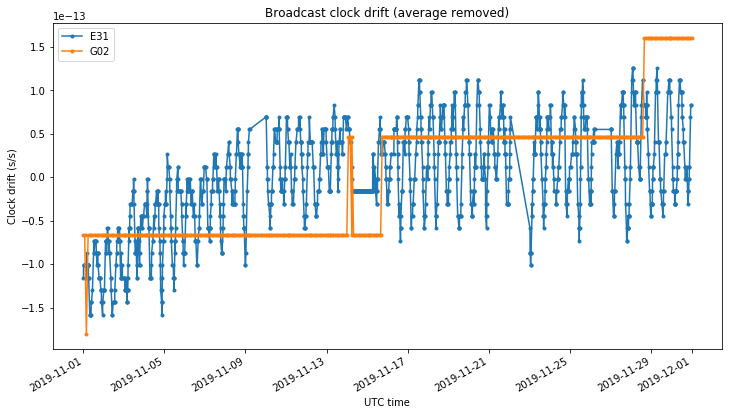

In [17]:
plt.figure(figsize = (12,6), facecolor = 'w')
detrend(data_gal['SVclockDrift'], 0).plot(marker = '.')
detrend(data_gps['SVclockDrift'], 0).plot(marker = '.')
plt.title('Broadcast clock drift (average removed)')
plt.xlabel('UTC time')
plt.ylabel('Clock drift (s/s)')
plt.legend(['E31', 'G02']);

The cell bellow shows that the GPS clock drift is constant except for a few jumps and some tiny jumps.

In [18]:
np.sort(data_gps['SVclockDrift'].dropna('time').diff('time').values)[::-1][:50]

array([1.13686838e-13, 1.13686838e-13, 1.13686838e-13, 1.13686838e-13,
       1.13686838e-13, 3.00014531e-24, 3.00014531e-24, 2.00009687e-24,
       2.00009687e-24, 2.00009687e-24, 2.00009687e-24, 2.00009687e-24,
       2.00009687e-24, 2.00009687e-24, 2.00009687e-24, 2.00009687e-24,
       2.00009687e-24, 2.00009687e-24, 2.00009687e-24, 2.00009687e-24,
       2.00009687e-24, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
       0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
       0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
       0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
       0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
       0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
       0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
       0.00000000e+00, 0.00000000e+00])

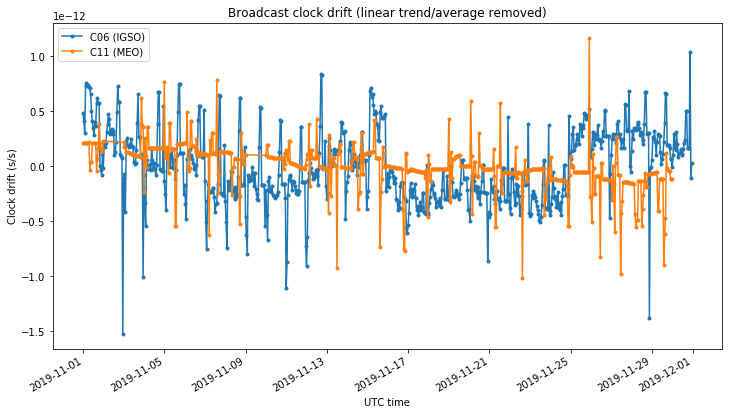

In [19]:
plt.figure(figsize = (12,6), facecolor = 'w')
detrend(data_bei_igso['SVclockDrift'], 1).plot(marker = '.')
detrend(data_bei_meo['SVclockDrift'], 0).plot(marker = '.')
plt.title('Broadcast clock drift (linear trend/average removed)')
plt.xlabel('UTC time')
plt.ylabel('Clock drift (s/s)')
plt.legend(['C06 (IGSO)', 'C11 (MEO)']);

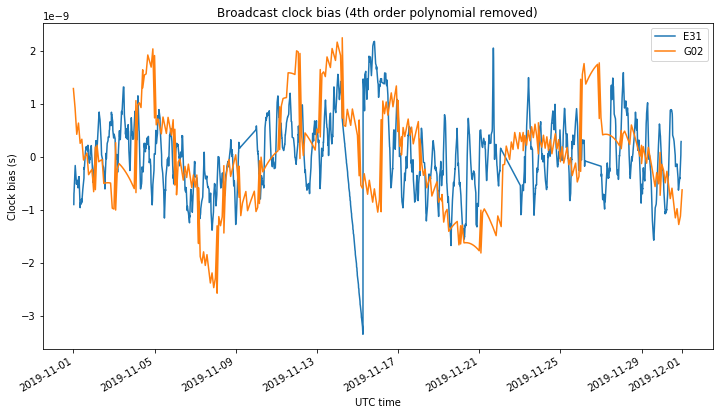

In [20]:
plt.figure(figsize = (12,6), facecolor = 'w')
detrend(data_gal['SVclockBias'], 4).plot()
detrend(data_gps['SVclockBias'], 4).plot()
plt.title('Broadcast clock bias (4th order polynomial removed)')
plt.xlabel('UTC time')
plt.ylabel('Clock bias (s)')
plt.legend(['E31', 'G02']);

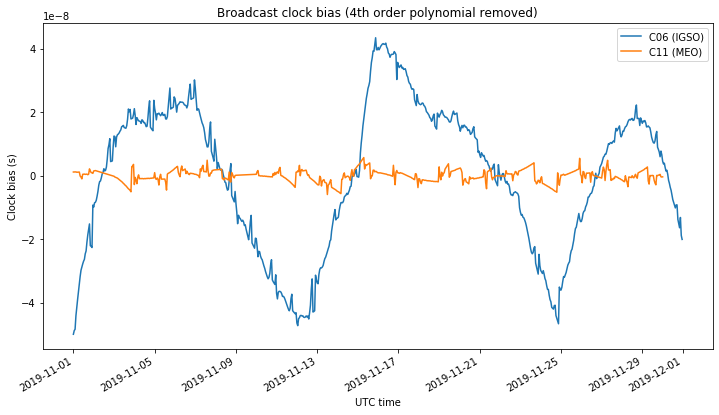

In [21]:
plt.figure(figsize = (12,6), facecolor = 'w')
detrend(data_bei_igso['SVclockBias'], 4).plot()
detrend(data_bei_meo['SVclockBias'], 4).plot()
plt.title('Broadcast clock bias (4th order polynomial removed)')
plt.xlabel('UTC time')
plt.ylabel('Clock bias (s)')
plt.legend(['C06 (IGSO)', 'C11 (MEO)']);

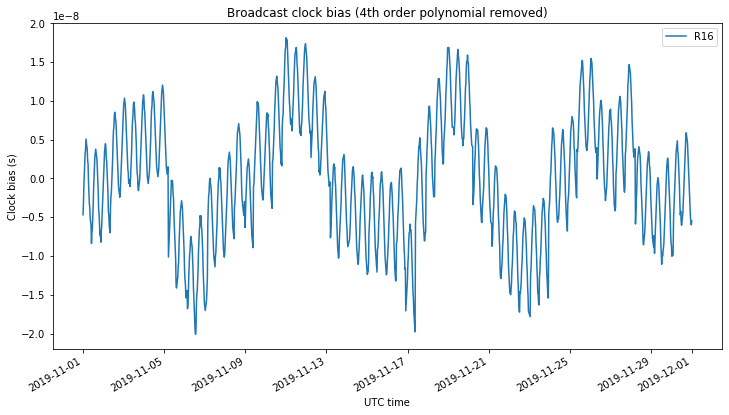

In [22]:
plt.figure(figsize = (12,6), facecolor = 'w')
detrend(data_glo['SVclockBias'], 4).plot()
plt.title('Broadcast clock bias (4th order polynomial removed)')
plt.xlabel('UTC time')
plt.ylabel('Clock bias (s)')
plt.legend(['R16']);

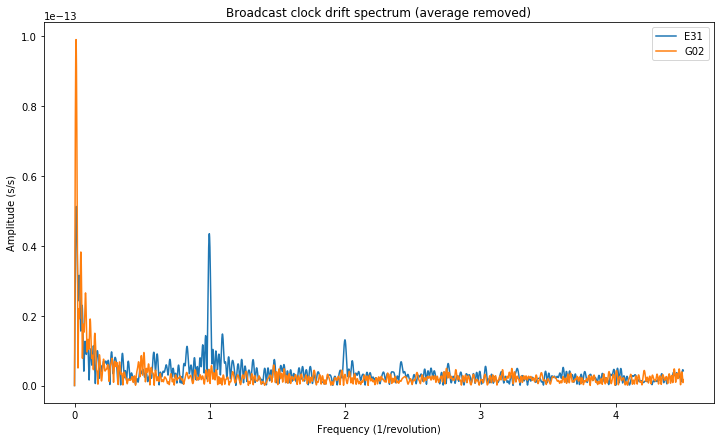

In [23]:
plt.figure(figsize = (12,7), facecolor = 'w')
fourier_analysis(data_gal['SVclockDrift'], n0(data_gal), 0)
fourier_analysis(data_gps['SVclockDrift'], n0(data_gps), 0)
plt.title('Broadcast clock drift spectrum (average removed)')
plt.xlabel('Frequency (1/revolution)')
plt.ylabel('Amplitude (s/s)')
plt.legend(['E31', 'G02']);

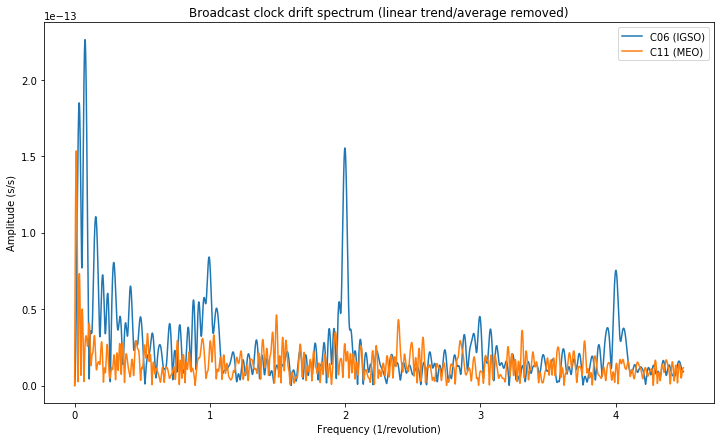

In [24]:
plt.figure(figsize = (12,7), facecolor = 'w')
fourier_analysis(data_bei_igso['SVclockDrift'], n0(data_bei_igso), 1)
fourier_analysis(data_bei_meo['SVclockDrift'], n0(data_bei_meo), 0)
plt.title('Broadcast clock drift spectrum (linear trend/average removed)')
plt.xlabel('Frequency (1/revolution)')
plt.ylabel('Amplitude (s/s)')
plt.legend(['C06 (IGSO)', 'C11 (MEO)']);

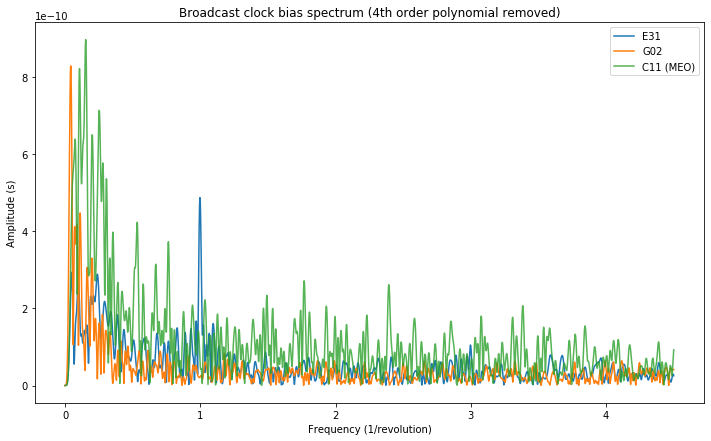

In [25]:
plt.figure(figsize = (12,7), facecolor = 'w')
fourier_analysis(data_gal['SVclockBias'], n0(data_gal), 4)
fourier_analysis(data_gps['SVclockBias'], n0(data_gps), 4)
fourier_analysis(data_bei_meo['SVclockBias'], n0(data_bei_meo), 4, alpha = 0.8)
plt.title('Broadcast clock bias spectrum (4th order polynomial removed)')
plt.xlabel('Frequency (1/revolution)')
plt.ylabel('Amplitude (s)')
plt.legend(['E31', 'G02', 'C11 (MEO)']);

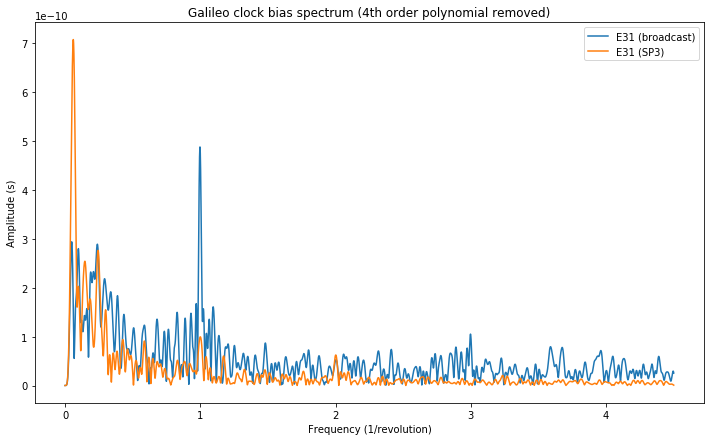

In [26]:
plt.figure(figsize = (12,7), facecolor = 'w')
fourier_analysis(data_gal['SVclockBias'], n0(data_gal), 4)
fourier_analysis(clk_gal, n0(data_gal), 4)
plt.title('Galileo clock bias spectrum (4th order polynomial removed)')
plt.xlabel('Frequency (1/revolution)')
plt.ylabel('Amplitude (s)')
plt.legend(['E31 (broadcast)', 'E31 (SP3)']);

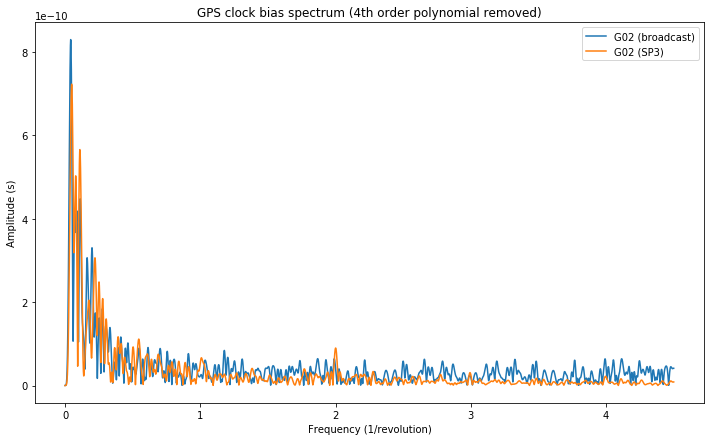

In [27]:
plt.figure(figsize = (12,7), facecolor = 'w')
fourier_analysis(data_gps['SVclockBias'], n0(data_gps), 4)
fourier_analysis(clk_gps, n0(data_gps), 4)
plt.title('GPS clock bias spectrum (4th order polynomial removed)')
plt.xlabel('Frequency (1/revolution)')
plt.ylabel('Amplitude (s)')
plt.legend(['G02 (broadcast)', 'G02 (SP3)']);

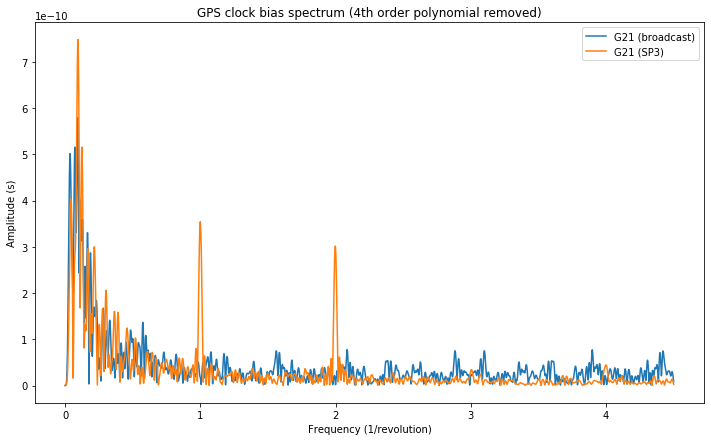

In [28]:
plt.figure(figsize = (12,7), facecolor = 'w')
fourier_analysis(data_gps_G21['SVclockBias'], n0(data_gps_G21), 4)
fourier_analysis(load_sp3_clk('G21'), n0(data_gps_G21), 4)
plt.title('GPS clock bias spectrum (4th order polynomial removed)')
plt.xlabel('Frequency (1/revolution)')
plt.ylabel('Amplitude (s)')
plt.legend(['G21 (broadcast)', 'G21 (SP3)']);

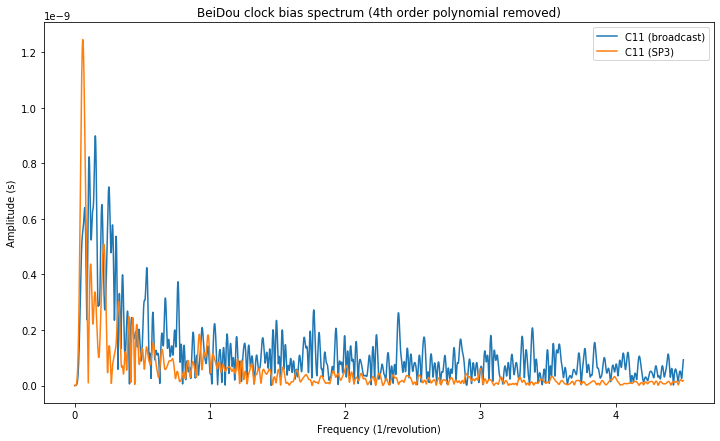

In [29]:
plt.figure(figsize = (12,7), facecolor = 'w')
fourier_analysis(data_bei_meo['SVclockBias'], n0(data_bei_meo), 4)
fourier_analysis(clk_bei_meo, n0(data_bei_meo), 4)
plt.title('BeiDou clock bias spectrum (4th order polynomial removed)')
plt.xlabel('Frequency (1/revolution)')
plt.ylabel('Amplitude (s)')
plt.legend(['C11 (broadcast)', 'C11 (SP3)']);

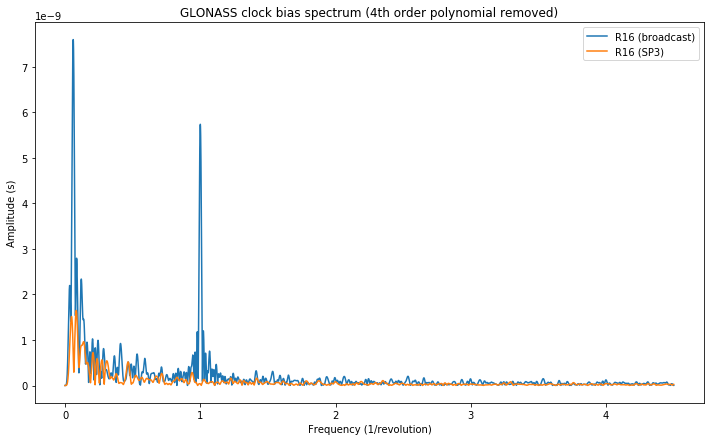

In [30]:
plt.figure(figsize = (12,7), facecolor = 'w')
fourier_analysis(data_glo['SVclockBias'], n0_glo, 4)
fourier_analysis(clk_glo, n0_glo, 4)
plt.title('GLONASS clock bias spectrum (4th order polynomial removed)')
plt.xlabel('Frequency (1/revolution)')
plt.ylabel('Amplitude (s)')
plt.legend(['R16 (broadcast)', 'R16 (SP3)']);

In [31]:
all_gals = {f.stem : fourier_extract(gr.load(f)) for f in pathlib.Path('nc').glob('E*.nc')}
operational_gals = {k : v for k, v in all_gals.items() if k not in ['E14', 'E18']}

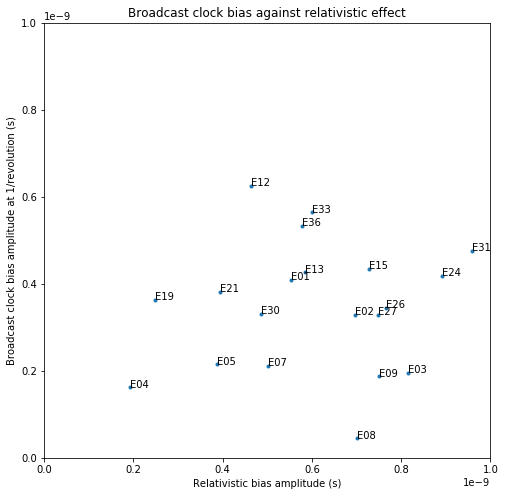

In [32]:
plt.figure(figsize = (8,8), facecolor = 'w')
for k,v in operational_gals.items():
    plt.plot(v[2].real, np.abs(v[0]), '.', color = 'C0')
    plt.annotate(k, (v[2].real, np.abs(v[0])))
plt.title('Broadcast clock bias against relativistic effect')
plt.xlabel('Relativistic bias amplitude (s)')
plt.ylabel('Broadcast clock bias amplitude at 1/revolution (s)')
plt.xlim((0,1e-9))
plt.ylim((0,1e-9));

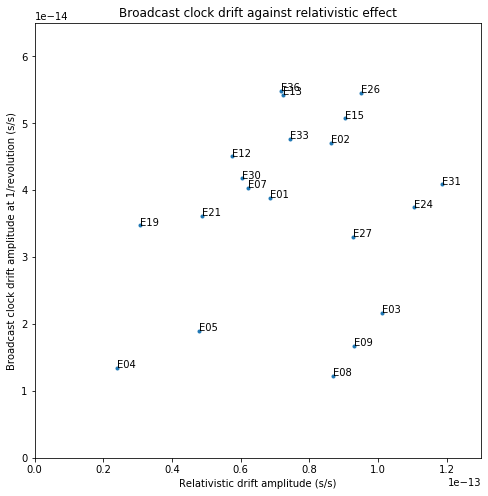

In [33]:
plt.figure(figsize = (8,8), facecolor = 'w')
for k,v in operational_gals.items():
    plt.plot(v[3].real, np.abs(v[1]), '.', color = 'C0')
    plt.annotate(k, (v[3].real, np.abs(v[1])))
plt.title('Broadcast clock drift against relativistic effect')
plt.xlabel('Relativistic drift amplitude (s/s)')
plt.ylabel('Broadcast clock drift amplitude at 1/revolution (s/s)')
plt.xlim((0,1.3e-13))
plt.ylim((0,0.65e-13));

LinregressResult(slope=0.6087695106371555, intercept=1.0798194069102662e-14, rvalue=0.8545843422844966, pvalue=4.128474213428766e-07, stderr=0.08272025117194741)


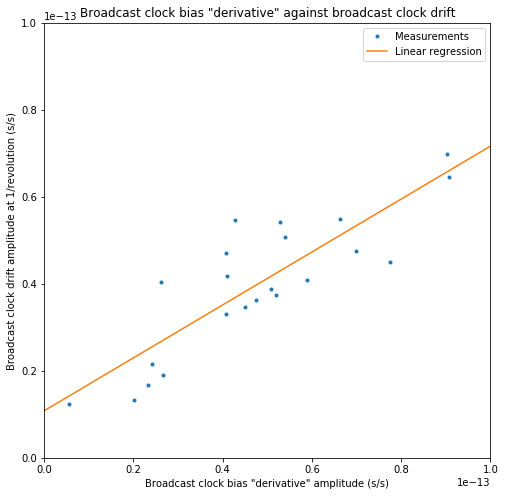

In [34]:
plt.figure(figsize = (8,8), facecolor = 'w')
x = [v[4].real * np.abs(v[0]) for v in all_gals.values()]
y = [np.abs(v[1]) for v in all_gals.values()]
plt.plot(x, y, '.')
l = scipy.stats.linregress(x,y)
plt.plot([0, 1e-13], [l.intercept, l.slope*1e-13 + l.intercept])
plt.title('Broadcast clock bias "derivative" against broadcast clock drift')
plt.xlabel('Broadcast clock bias "derivative" amplitude (s/s)')
plt.ylabel('Broadcast clock drift amplitude at 1/revolution (s/s)')
plt.xlim((0,1e-13))
plt.ylim((0,1e-13))
plt.legend(['Measurements', 'Linear regression'])
print(l)

In [35]:
np.corrcoef(x,y)

array([[1.        , 0.85458434],
       [0.85458434, 1.        ]])

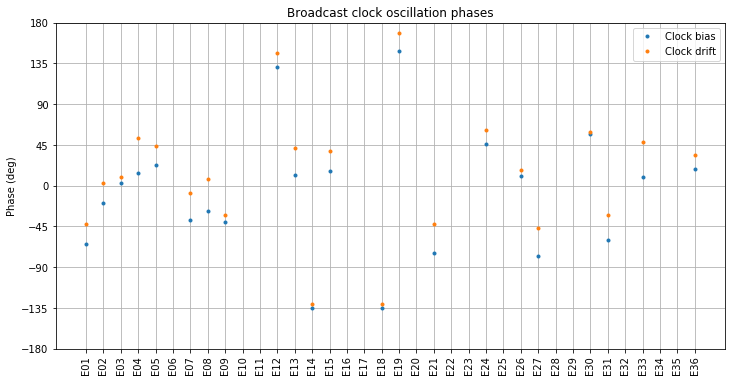

In [36]:
plt.figure(figsize = (12,6), facecolor = 'w')
svns = [int(k[1:]) for k in all_gals.keys()]
plt.plot(svns, [np.rad2deg(np.angle(-v[0])) for v in all_gals.values()], '.')
plt.plot(svns, [np.rad2deg(np.angle(-v[1])) for v in all_gals.values()], '.')
plt.ylim((-180, 180))
plt.xticks(np.arange(1,37), [f'E{svn:02d}' for svn in range(1,37)], rotation = 'vertical');
plt.yticks(np.arange(-180,180+45,45))
plt.grid()
plt.title('Broadcast clock oscillation phases')
plt.ylabel('Phase (deg)')
plt.legend(['Clock bias', 'Clock drift']);

LinregressResult(slope=0.9994387319476977, intercept=20.381945378635884, rvalue=0.9864367101437211, pvalue=3.5956889518469716e-17, stderr=0.03718705959641042)


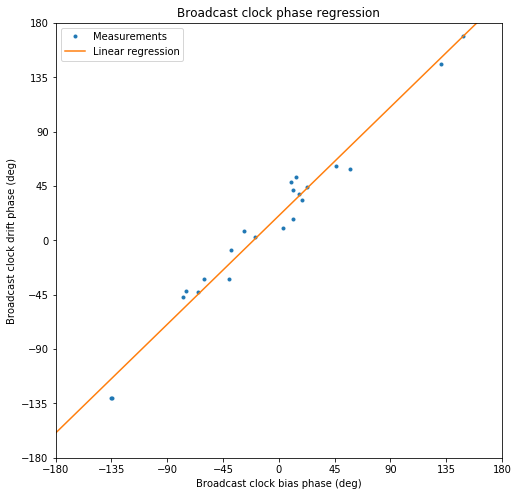

In [45]:
plt.figure(figsize = (8,8), facecolor  = 'w')
x = np.array([np.rad2deg(np.angle(-v[0])) for v in all_gals.values()])
y = np.array([np.rad2deg(np.angle(-v[1])) for v in all_gals.values()])
plt.ylim((-180,180))
plt.xlim((-180,180))
plt.xticks(np.arange(-180,180+45,45))
plt.yticks(np.arange(-180,180+45,45))
plt.plot(x, y, '.')
l = scipy.stats.linregress(x,y)
plt.plot([-180, 180], [-180*l.slope + l.intercept, 180*l.slope + l.intercept])
plt.xlabel('Broadcast clock bias phase (deg)')
plt.ylabel('Broadcast clock drift phase (deg)')
plt.title('Broadcast clock phase regression')
plt.legend(['Measurements', 'Linear regression'])
print(l)

In [38]:
np.average(x-y), np.std(x-y)

(-20.386570036195454, 11.473858717063976)

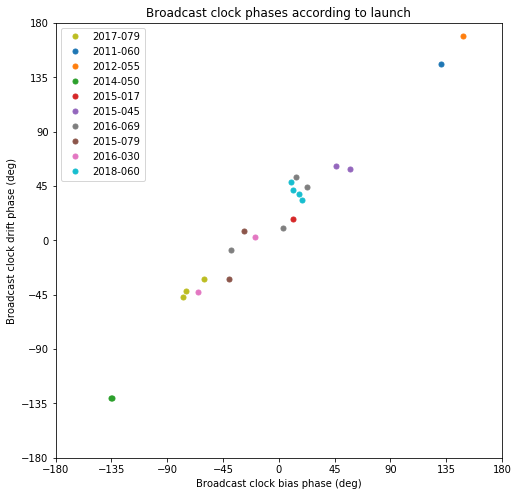

In [44]:
orbital_planes = {'E11': 'B', 'E12': 'B', 'E19': 'C', 'E20': 'C', 'E26': 'B',\
                  'E22': 'B', 'E24': 'A', 'E30': 'A', 'E08': 'C', 'E09': 'C',\
                  'E01': 'A', 'E02': 'A', 'E07': 'C', 'E03': 'C', 'E04': 'C',\
                  'E05': 'C', 'E21': 'A', 'E25': 'A', 'E27': 'A', 'E31': 'A',\
                  'E36': 'B', 'E13': 'B', 'E15': 'B', 'E33': 'B', 'E14': 'Ext', 'E18' : 'Ext'}
launches = {'E11': '2011-060', 'E12': '2011-060', 'E19': '2012-055', 'E20': '2012-055',\
            'E18': '2014-050', 'E14': '2014-050', 'E26': '2015-017', 'E22': '2015-017',\
            'E24': '2015-045', 'E30': '2015-045', 'E08': '2015-079', 'E09': '2015-079',\
            'E01': '2016-030', 'E02': '2016-030', 'E07': '2016-069', 'E03': '2016-069',\
            'E04': '2016-069', 'E05': '2016-069', 'E21': '2017-079', 'E25': '2017-079',\
            'E27': '2017-079', 'E31': '2017-079', 'E36': '2018-060', 'E13': '2018-060',\
            'E15': '2018-060', 'E33': '2018-060'}
launch_set = sorted(set(launches.values()))
plane_colours = {'A' : 'C0', 'B' : 'C1', 'C' : 'C2', 'Ext' : 'C3'}
launch_colours = {k : f'C{j}' for j, k in enumerate(launch_set)}
launch_label_done = {k : False for k in launch_set}
plt.figure(figsize = (8,8), facecolor = 'w')
for k, v in all_gals.items():
    launch = launches[k]
    kwargs = {'label' : launch} if not launch_label_done[launch] else {}
    plt.plot([np.rad2deg(np.angle(-v[0]))], [np.rad2deg(np.angle(-v[1]))], '.',\
             color = launch_colours[launch], markersize = 10, **kwargs)
    launch_label_done[launch] = True
plt.ylim((-180,180))
plt.xlim((-180,180))
plt.xticks(np.arange(-180,180+45,45))
plt.yticks(np.arange(-180,180+45,45))
plt.xlabel('Broadcast clock bias phase (deg)')
plt.ylabel('Broadcast clock drift phase (deg)')
plt.title('Broadcast clock phases according to launch')
plt.legend();

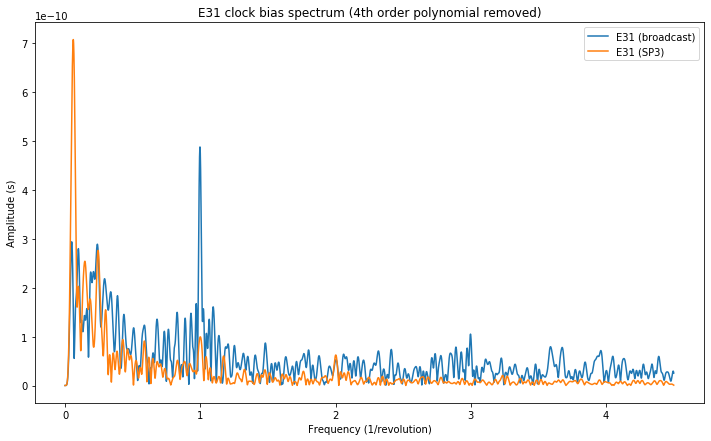

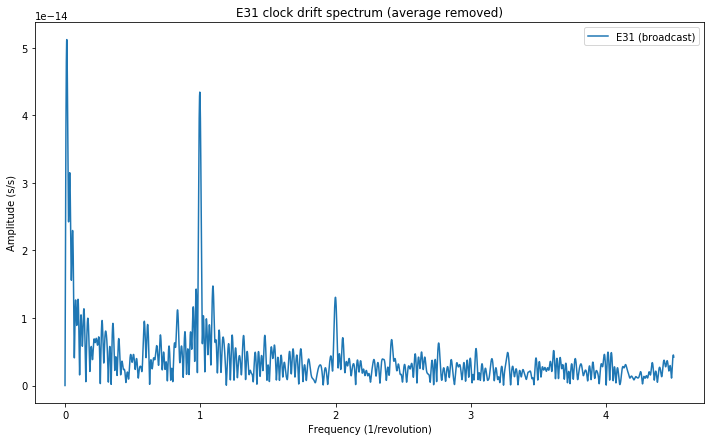

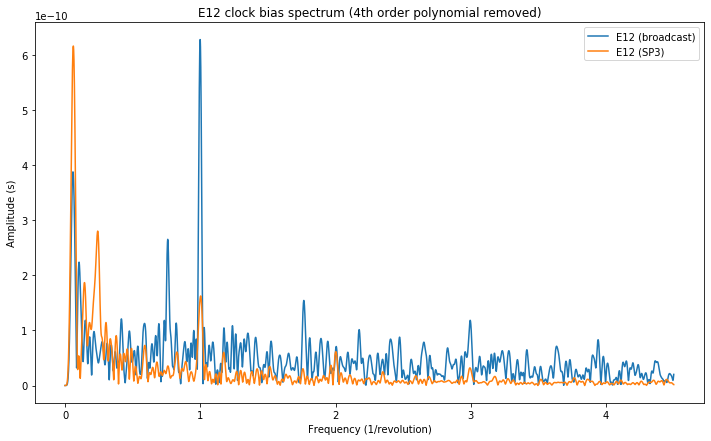

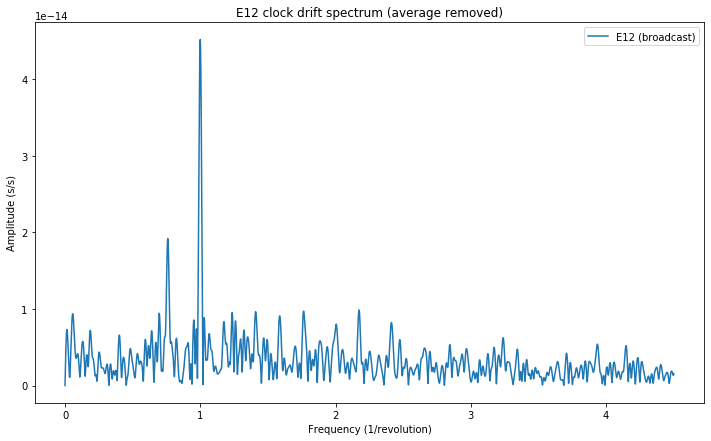

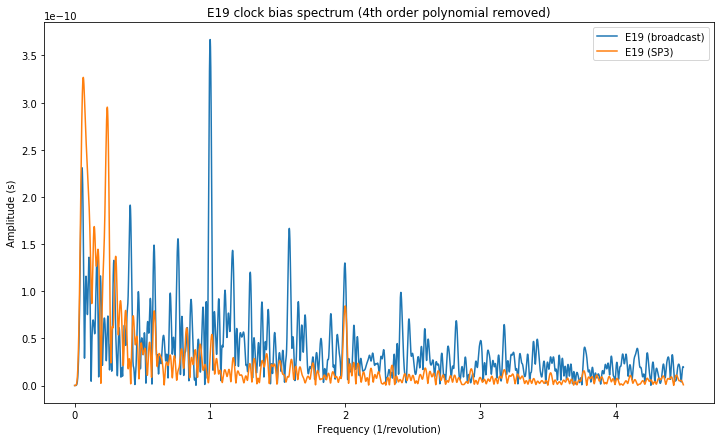

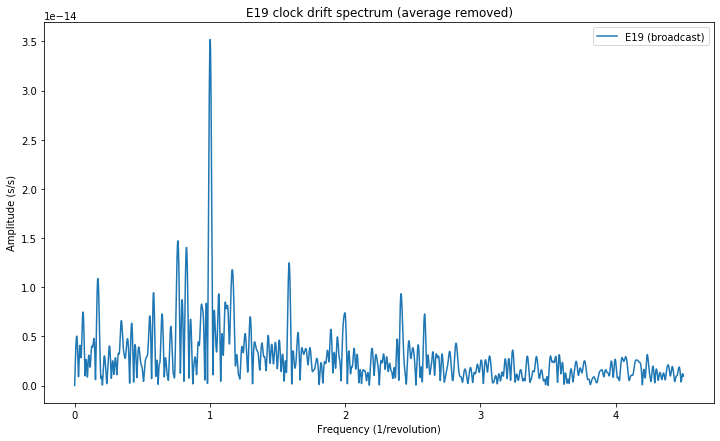

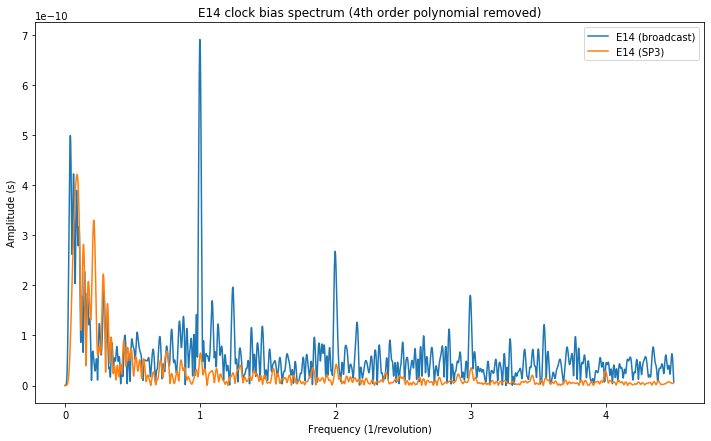

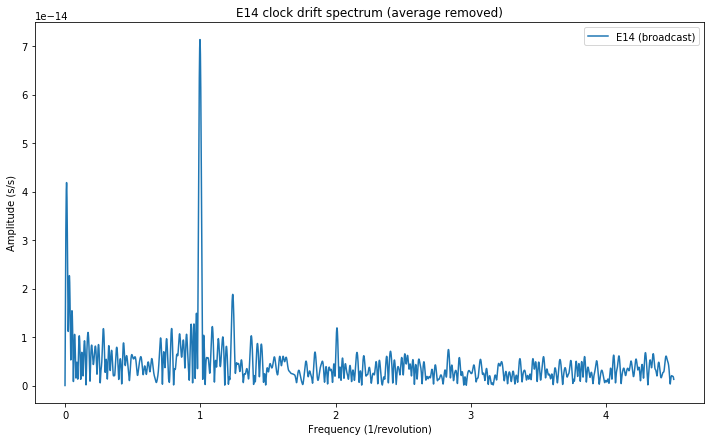

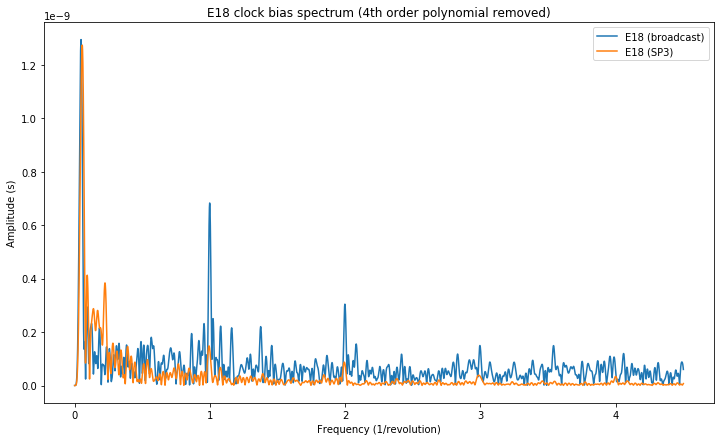

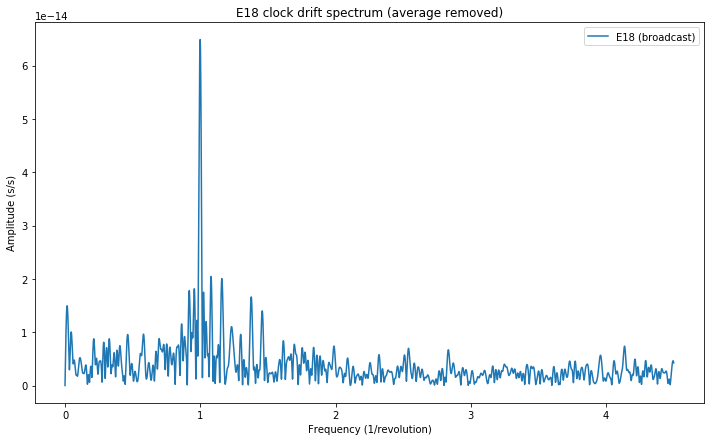

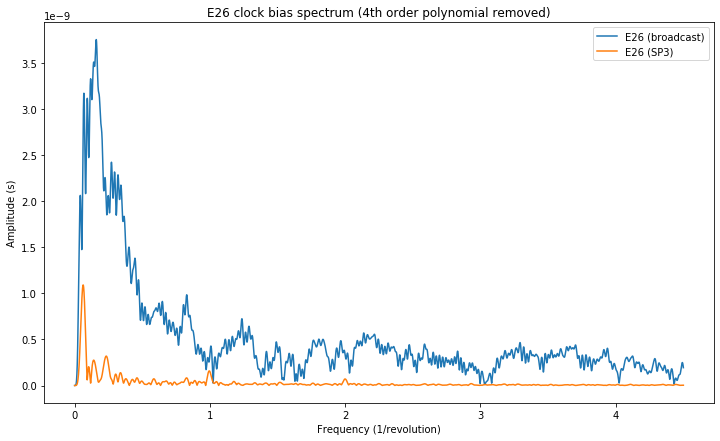

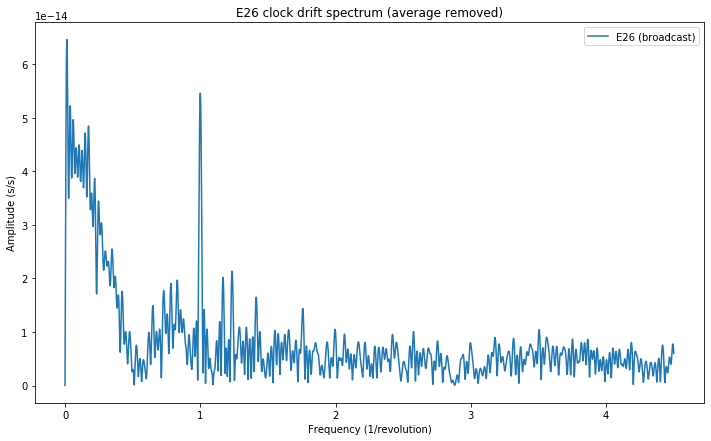

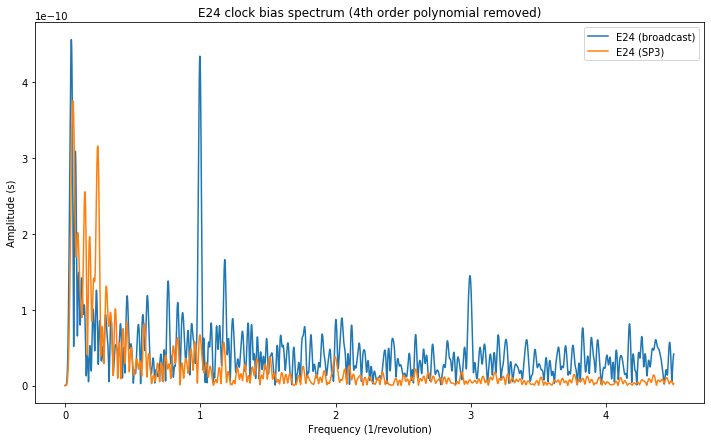

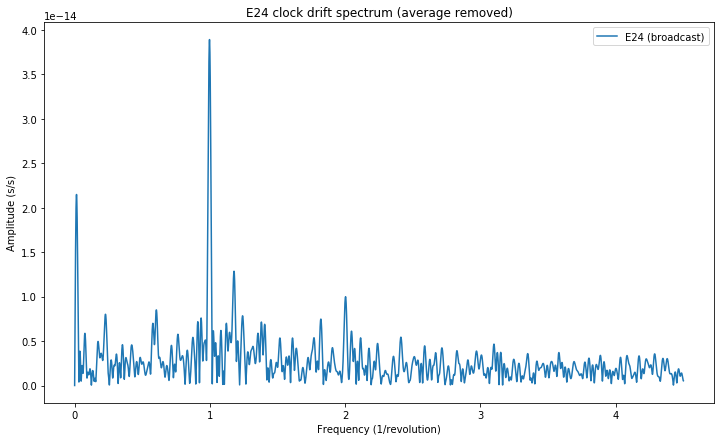

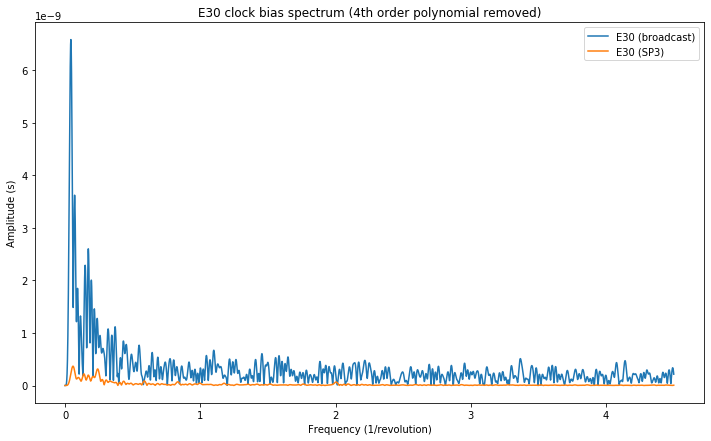

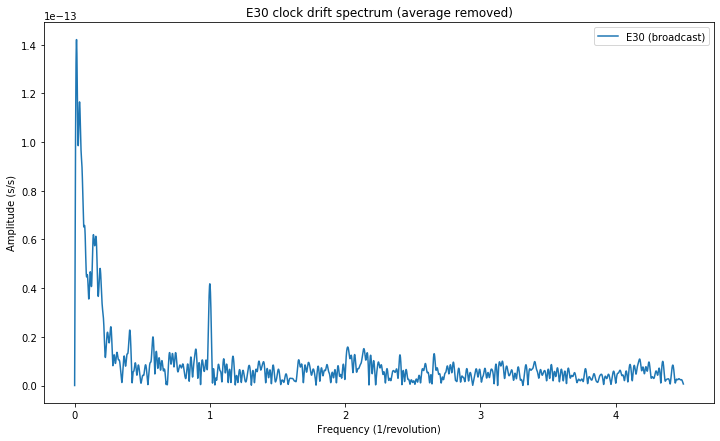

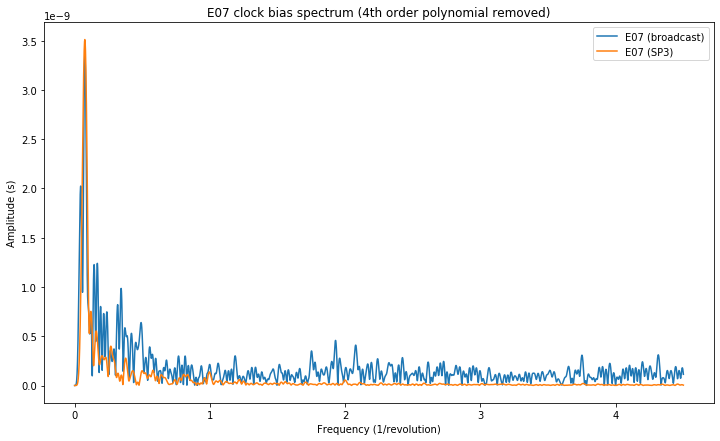

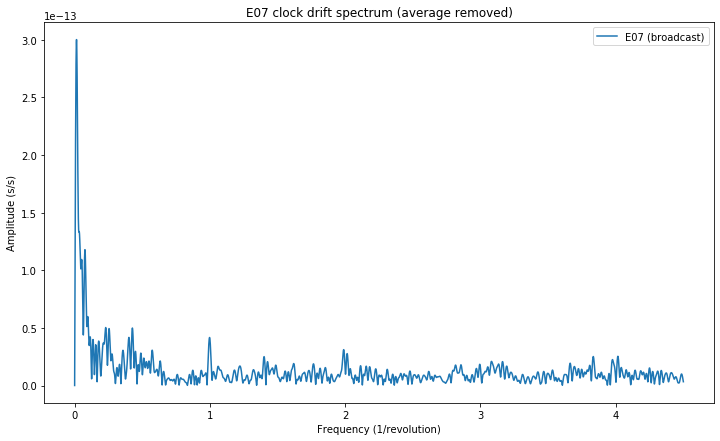

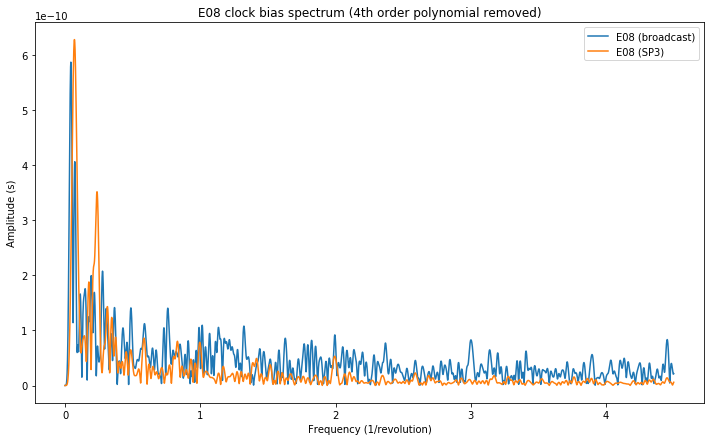

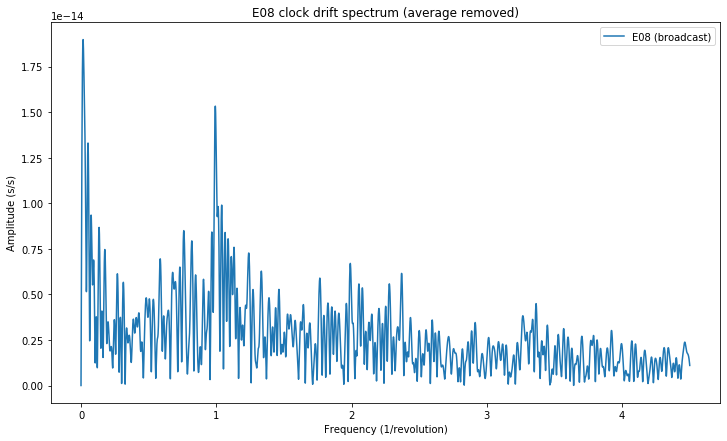

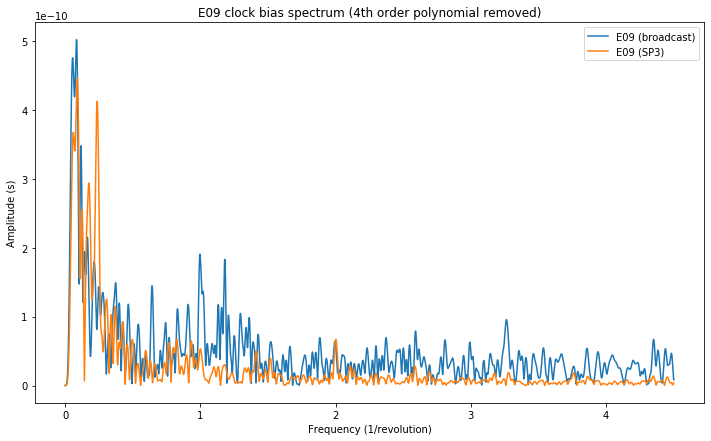

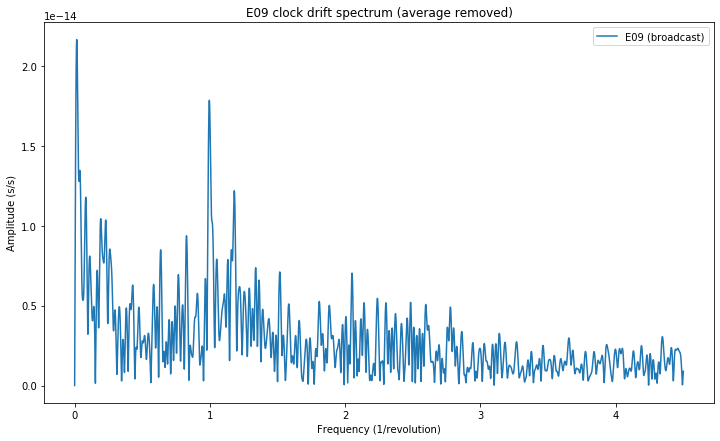

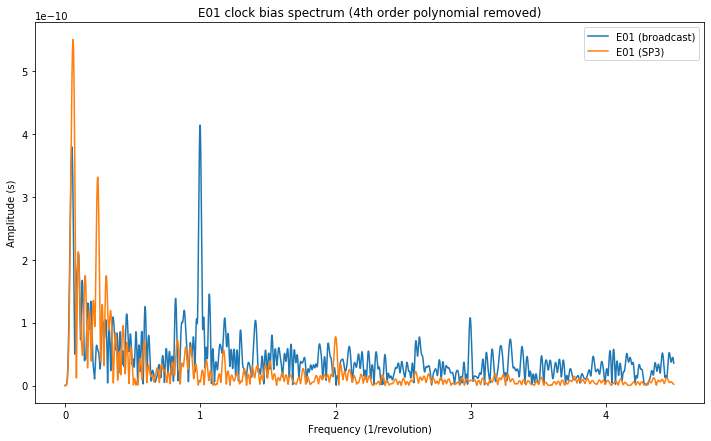

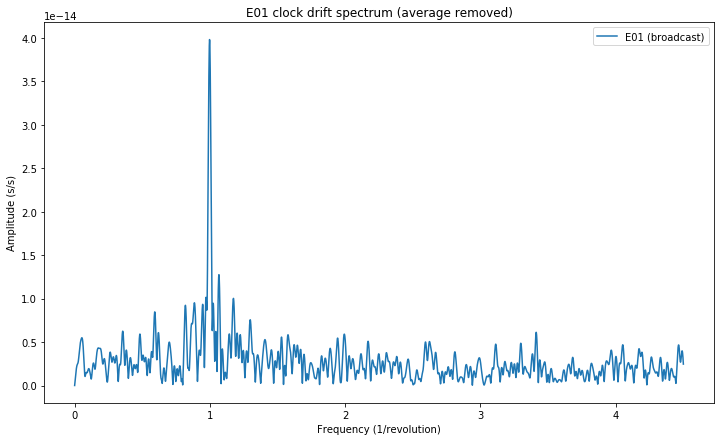

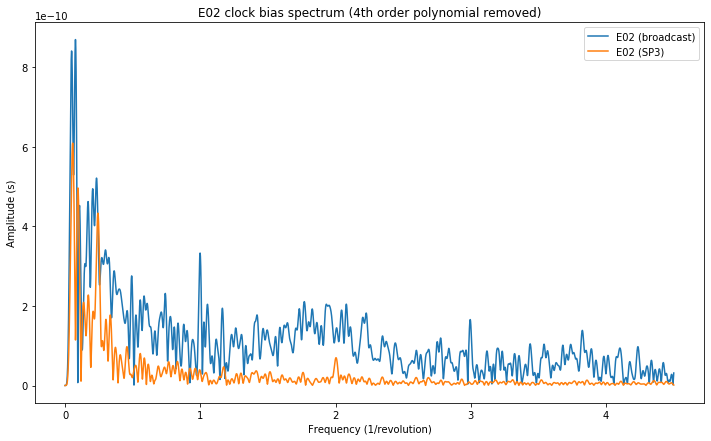

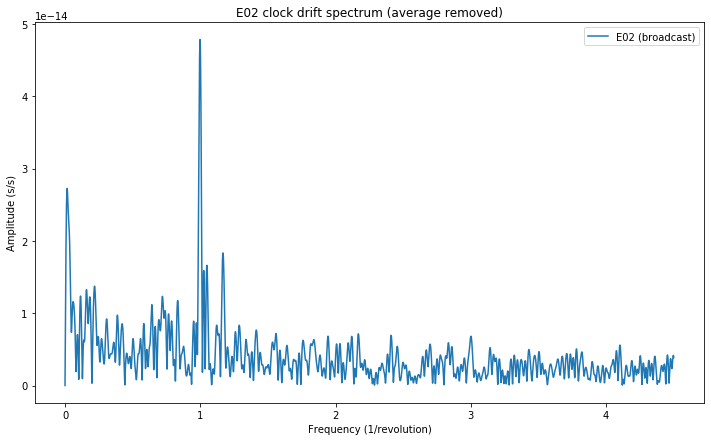

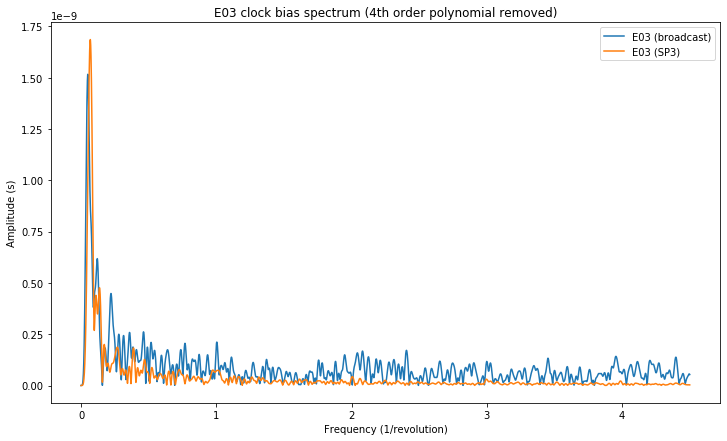

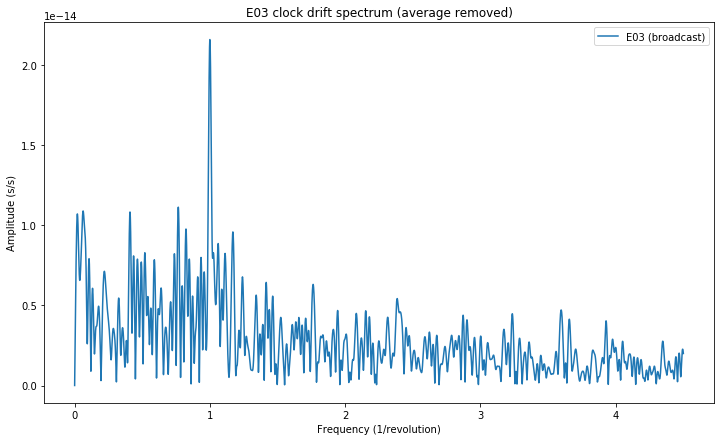

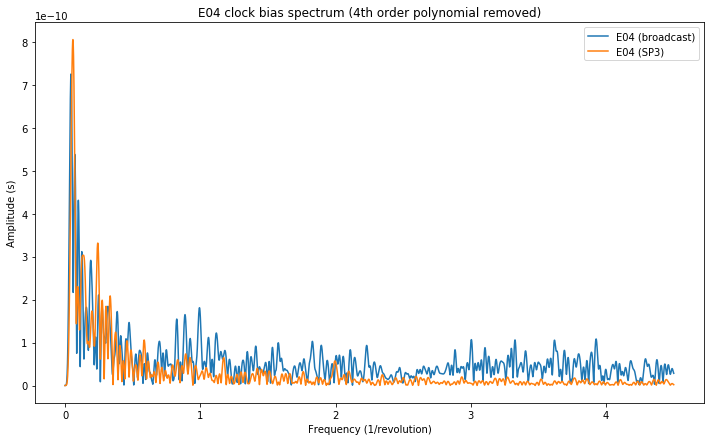

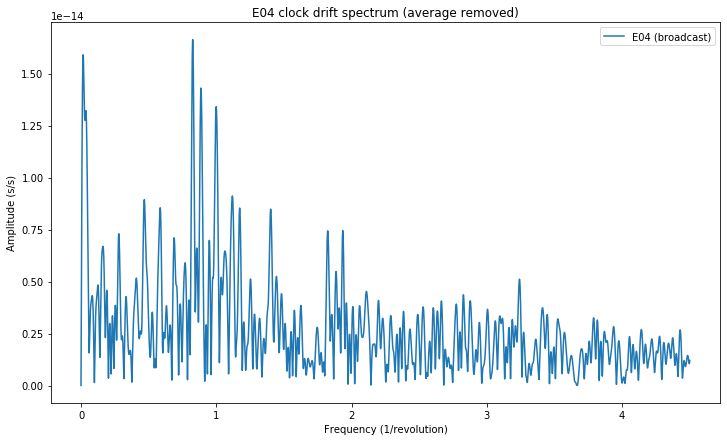

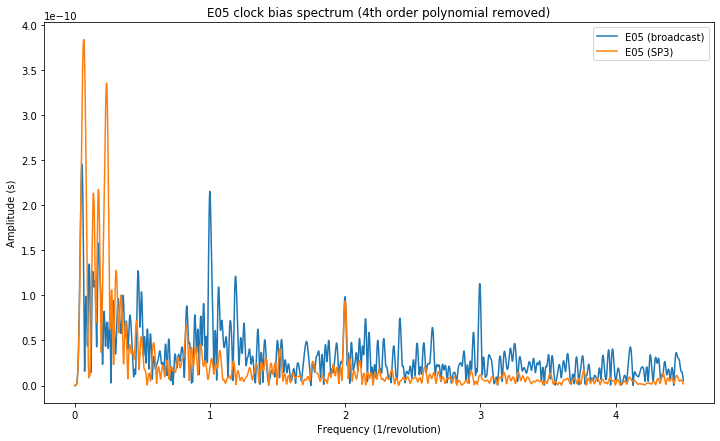

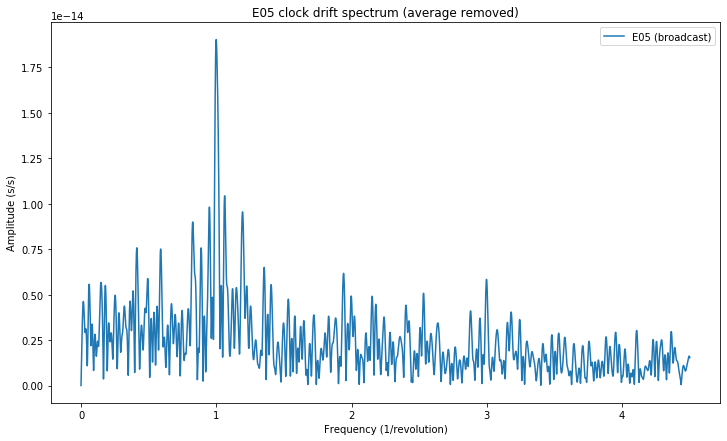

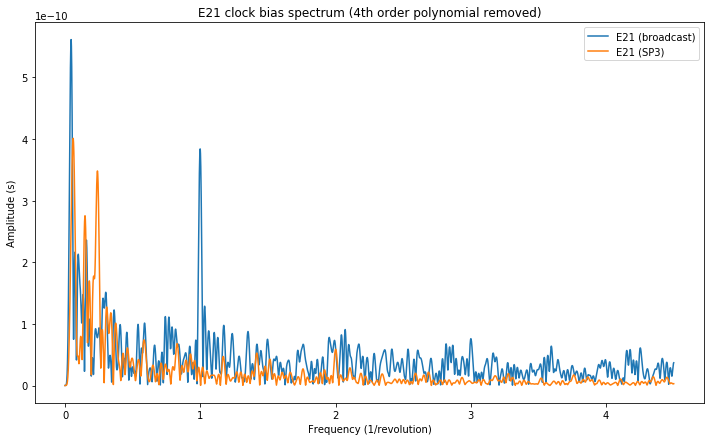

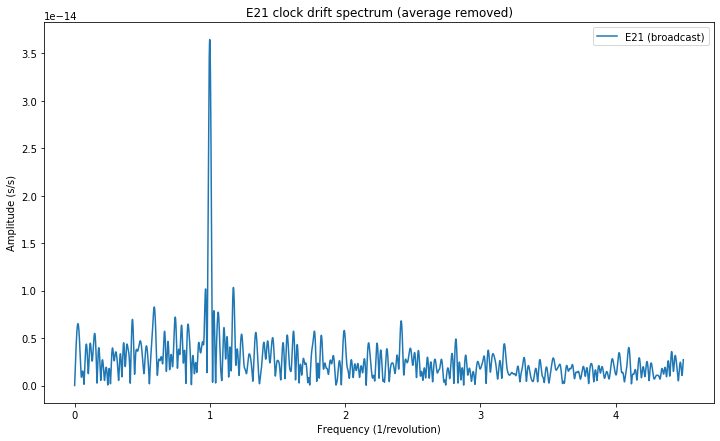

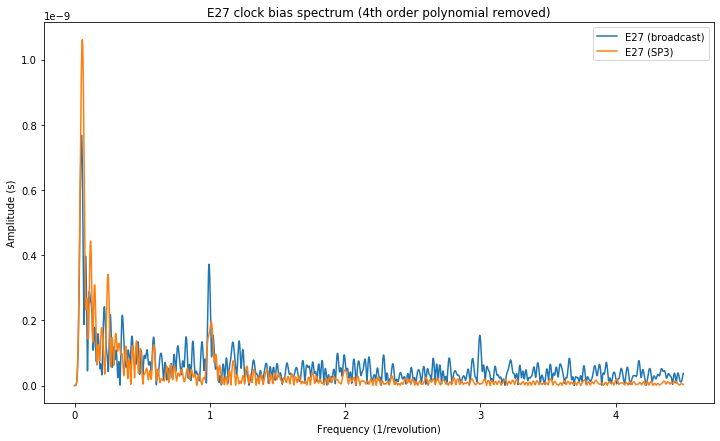

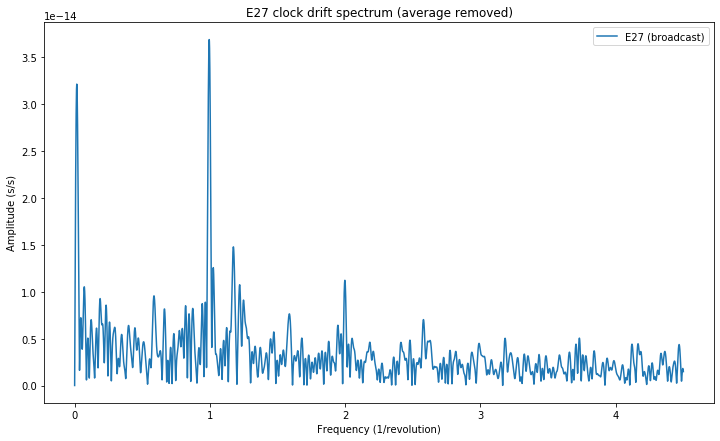

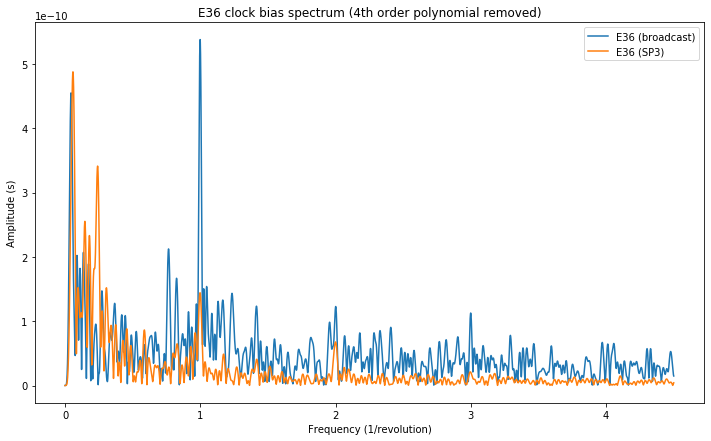

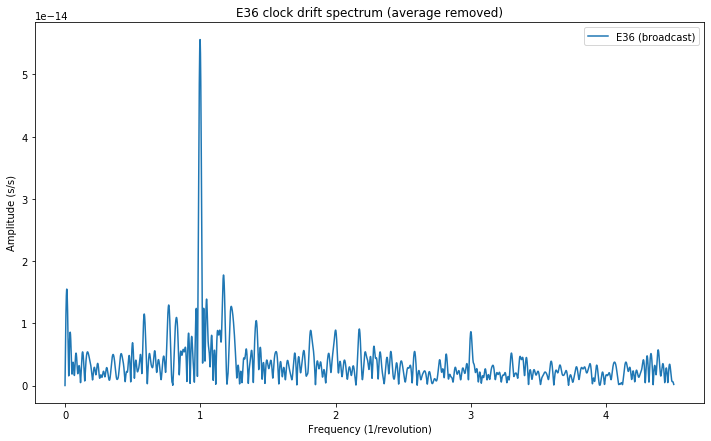

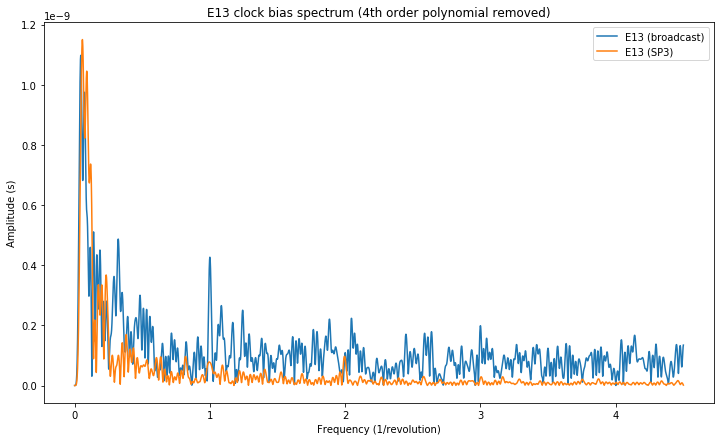

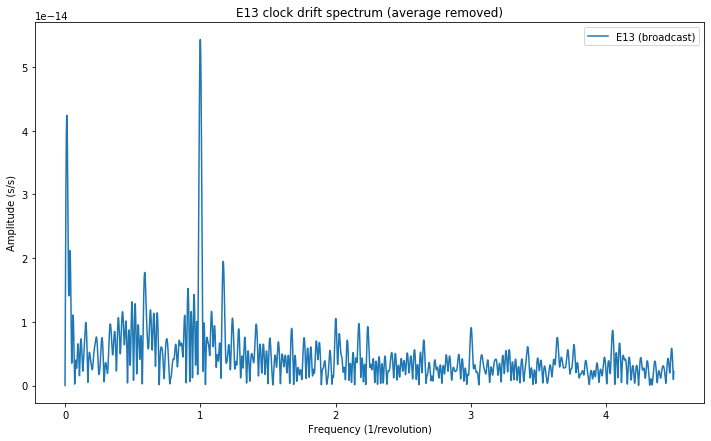

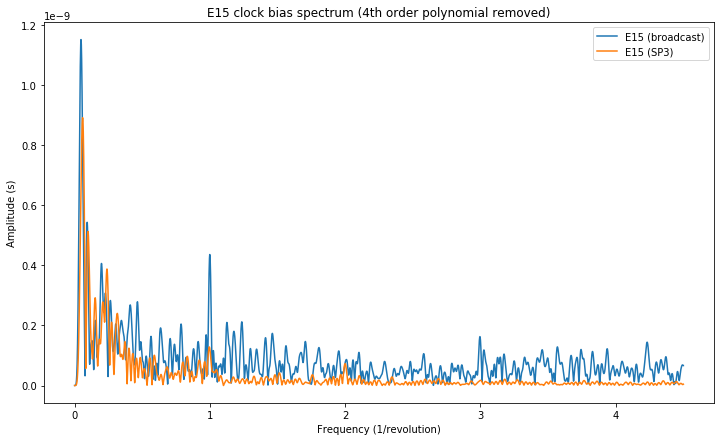

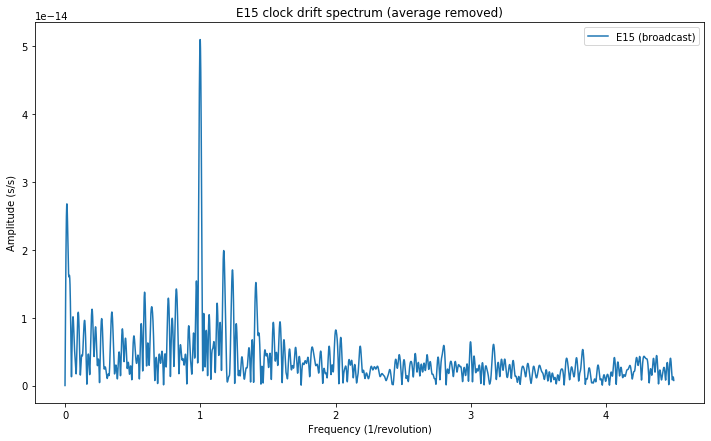

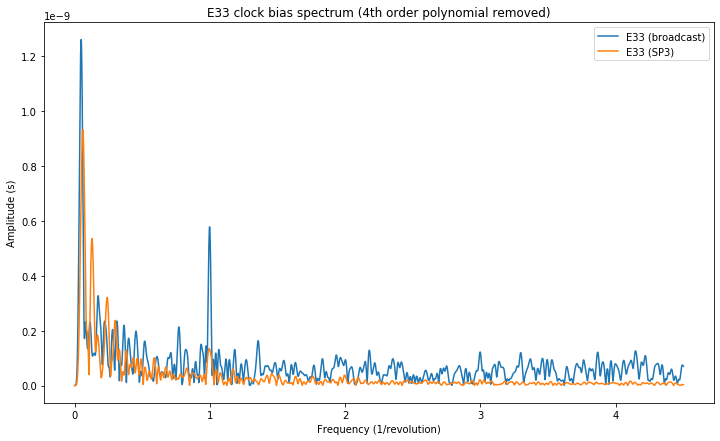

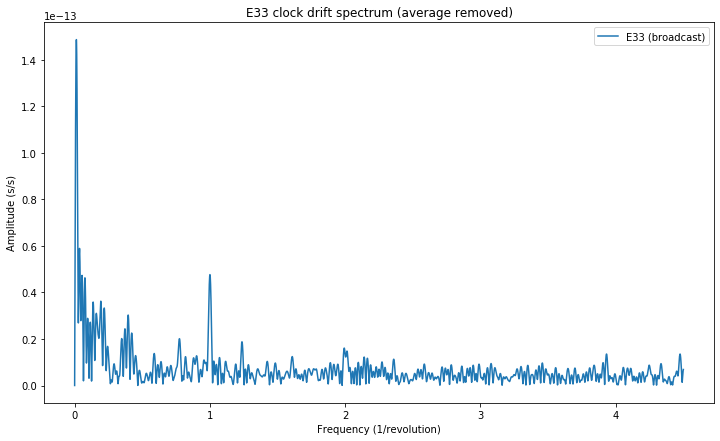

In [40]:
for f in pathlib.Path('nc').glob('E*.nc'):
    plt.figure(figsize = (12,7), facecolor = 'w')
    dg = gr.load(f)
    fourier_analysis(dg['SVclockBias'], n0(dg), 4)
    svn = f.stem
    fourier_analysis(load_sp3_clk(svn), n0(dg), 4)
    plt.title(f'{svn} clock bias spectrum (4th order polynomial removed)')
    plt.xlabel('Frequency (1/revolution)')
    plt.ylabel('Amplitude (s)')
    plt.legend([f'{svn} (broadcast)', f'{svn} (SP3)'])
    
    plt.figure(figsize = (12,7), facecolor = 'w')
    fourier_analysis(dg['SVclockDrift'], n0(dg), 0)
    plt.title(f'{svn} clock drift spectrum (average removed)')
    plt.xlabel('Frequency (1/revolution)')
    plt.ylabel('Amplitude (s/s)')
    plt.legend([f'{svn} (broadcast)'])